In [362]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, GlobalMaxPooling1D, Flatten, Conv1D, Dropout, Activation
from keras.preprocessing.text import Tokenizer

import tensorflow as tf
import numpy as np
import pandas as pd

import os
import re
import string

import re
import time
#import helpers.pickle_helpers as ph
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [363]:
print(tf.test.is_gpu_available())

True


In [364]:
#configuration GPU
# Hyperparams if GPU is available
if tf.test.is_gpu_available():
    # GPU
    BATCH_SIZE = 128 # Number of examples used in each iteration
    EPOCHS = 2 # Number of passes through entire dataset
    VOCAB_SIZE = 30000 # Size of vocabulary dictionary
    MAX_LEN = 500 # Max length of review (in words)
    EMBEDDING_DIM = 40 # Dimension of word embedding vector

# Hyperparams for CPU training
else:
    # CPU
    BATCH_SIZE = 32
    EPOCHS = 2
    VOCAB_SIZE = 20000
    MAX_LEN = 90
    EMBEDDING_DIM = 40

In [365]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [366]:
data = pd.read_csv('final_data.csv')
data = data.dropna() 
print(data.shape,data['intent'].unique())
data.head()

(20273, 2) [0. 1.]


,text,intent
0,0000000000000000000 nulle,0.0
1,marzen mleyektou,0.0
2,يا سي امين ممسطك وليت والله بففففففففففف,0.0
3,M3alem hhhhhhh,1.0
4,عسل حسين عسل,1.0


In [367]:
data['intent'].unique()

array([0., 1.])

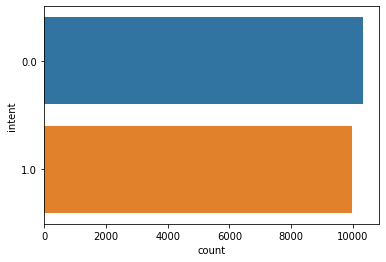

In [368]:
sns.countplot(y="intent", data=data)

In [369]:
data["text"].head()

0                   0000000000000000000 nulle
1                            marzen mleyektou
2    يا سي امين ممسطك وليت والله بففففففففففف
3                              M3alem hhhhhhh
4                                عسل حسين عسل
Name: text, dtype: object

In [370]:
#ajouter une colonne pour le nombre de mot de chaque ligne/commentaire
# retain only text that contain less that 70 tokens to avoid too much padding
data["token_size"] = data["text"].apply(lambda x: len(x.split(" ")))#recuprer le nb de mots pour chaque phrase/commentaire
data = data.loc[data['token_size'] < 70].copy()

# sampling : extract aleatoirement un echantillon de 20000 
#data = data.sample(n=20000,replace=True);#replace=True : pour les grands echantillons
#data = data.sample(n=5000,replace=True);

In [371]:
print(data.shape)
data.head()

(20202, 3)


,text,intent,token_size
0,0000000000000000000 nulle,0.0,2
1,marzen mleyektou,0.0,2
2,يا سي امين ممسطك وليت والله بففففففففففف,0.0,7
3,M3alem hhhhhhh,1.0,2
4,عسل حسين عسل,1.0,3


In [372]:
# This class creates a word -> index mapping (e.g,. "dad" -> 5) and vice-versa 
# (e.g., 5 -> "dad") for the dataset
class ConstructVocab():#creation d'une classe + 5 attributs + 1 methode
    def __init__(self, sentences):
        self.sentences = sentences
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()
        
    def create_index(self):
        for s in self.sentences:
            # update with individual tokens
            self.vocab.update(s.split(' '))
            
        # sort the vocab
        self.vocab = sorted(self.vocab)

        # add a padding token with index 0
        self.word2idx['<pad>'] = 0
        
        # word to index mapping
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1 # +1 because of pad token
        
        # index to word mapping
        for word, index in self.word2idx.items():
            self.idx2word[index] = word  

In [373]:
#extraction du vocabulaire = tt les mots du dataset
# construct vocab and indexing
inputs = ConstructVocab(data["text"].values.tolist())

# examples of what is in the vocab
inputs.vocab #vocabulaire trié par nom (vocabulaire = tt les mots dans le dataset)
inputs.idx2word#vocabulaire trié par nom  +indexé 2d (index : word)
inputs.word2idx#vocabulaire trié par nom + indexé 2d (word : index)
inputs.sentences#les phrases/lignes/commentaire
inputs.vocab

['',
 '\n',
 '\n79',
 '\nComment',
 '!',
 '!!',
 '!!!',
 '!!!!',
 '!!!!!',
 '!!!!!!',
 '!!!!!!!',
 '!!!!!!!!',
 '!!!!!!!!!',
 '!!!!!!!!!!!',
 '!!!!!!!!!!!!',
 '!!!!!!!!!!!!!',
 '!!!!!!!!!!!!!!',
 '!!!!!!!!!!!!!!!',
 '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!',
 '!!!!!!!!Raaaajel',
 '!!!!!_x000D_',
 '!!!!!؟؟؟؟ههههههه',
 '!!!!!سكر',
 '!!!!عاهرة',
 '!!!"',
 '!!!؟؟',
 '!!!إقول',
 '!!!بن',
 '!!)',
 '!!?',
 '!!_x000D_',
 '!!sma3tha',
 '!!ربي',
 '!"',
 '!3ejbetni',
 '!?',
 '!،',
 '!خيييييتت',
 '"',
 '""30',
 '""سنة',
 '"#أيمن',
 '")',
 '"3amlet',
 '"7lwa',
 '"9adech',
 '"A3leeeeem',
 '"A7la',
 '"Akid',
 '"Ana',
 '"Bekketni',
 '"Bravo',
 '"Chakib',
 '"Dawrha',
 '"Ena',
 '"Eu_x000D_',
 '"FINOU"',
 '"Fja3ni',
 '"Flob',
 '"Hali',
 '"Hhhhhhhh',
 '"Kader_x000D_',
 '"Kan.3malte.skatich,',
 '"Kelmet',
 '"Kif',
 '"La',
 '"Le',
 '"Ma7la',
 '"Madam',
 '"Mamstou',
 '"Maset',
 '"Masta',
 '"Moch',
 '"Nchallah',
 '"Sa7bi',
 '"Si',
 '"Tbarkallah',
 '"Tfihh',
 '"Wlhhh',
 '"Ya',
 '"Ya3tik',
 '"Yasee

In [374]:
#convertir/remplacer les mots des lignes par ses index
# vectorize to tensor 
input_tensor = [[inputs.word2idx[s] for s in es.split(' ')]  for es in data["text"].values.tolist()]
input_tensor

[[897, 15464],
 [13301, 14177],
 [38080, 29554, 24627, 34829, 37632, 36590, 25772],
 [3816, 10140],
 [30655, 27951, 30655],
 [8933, 14606, 18609, 12380, 13834, 1964, 9020, 8511],
 [20206],
 [1677, 16447, 8270, 19805, 490],
 [10734,
  7446,
  8054,
  6398,
  17683,
  9063,
  15968,
  9608,
  7445,
  19660,
  17816,
  11897,
  15890,
  14780,
  16527,
  7,
  18422,
  18492,
  16809,
  16735,
  10616],
 [13076,
  13174,
  15494,
  12621,
  15494,
  1101,
  9407,
  17051,
  19789,
  1730,
  11351,
  2311,
  2344,
  17936],
 [29030, 28601, 37210],
 [4821, 9805],
 [4952, 13377, 16098, 11802],
 [34719,
  27873,
  34161,
  20326,
  31849,
  37580,
  20326,
  30331,
  34193,
  22132,
  20326,
  33166,
  36018,
  10,
  29173],
 [25488, 27625, 38049, 28635, 38573, 28821, 34509, 34509, 2485],
 [33303, 32347],
 [40040],
 [30863, 23320],
 [24169],
 [3274, 19417, 9293],
 [32306, 28144, 36179, 32306, 31852, 21892, 32961],
 [21713,
  30239,
  36179,
  21713,
  28538,
  481,
  24837,
  32491,
  36179,
 

In [375]:
#retourner la phrase la plus longue
def max_length(tensor):
    return max(len(t) for t in tensor)
# calculate the max_length of input tensor
max_length_inp = max_length(input_tensor)
print(max_length_inp)

69


In [376]:
#kima get dummies ama par rapport longueur des phrases
# Padding the input and output tensor to the maximum length
input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, 
                                                             maxlen=max_length_inp,
                                                             padding='post')
input_tensor[0:2]

array([[  897, 15464,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [13301, 14177,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     

In [377]:
#Binarization : kima get dummies lel target mara hédhi
### convert targets to one-hot encoding vectors
emotions = list(set(data.intent.unique()))
num_emotions = len(emotions)
# binarizer
mlb = preprocessing.MultiLabelBinarizer()
data_labels =  [set(emos) & set(emotions) for emos in data[['intent']].values]
bin_emotions = mlb.fit_transform(data_labels)
target_tensor = np.array(bin_emotions.tolist())
target_tensor[0:2] #colonne 0.0 , colonne 1.0

array([[1, 0],
       [1, 0]])

In [378]:
#convertion 2 columns targets -> 1 column target
get_emotion = lambda t: np.argmax(t)
print(get_emotion(target_tensor[0]))
emotion_dict = {0: 'negative', 1: 'positive'}
print(emotion_dict[get_emotion(target_tensor[0])])

0
negative


In [379]:
#division des données 80% train + 10% validation + 10% test
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Split the validataion further to obtain a holdout dataset (for testing) -- split 50:50
input_tensor_val, input_tensor_test, target_tensor_val, target_tensor_test = train_test_split(input_tensor_val, target_tensor_val, test_size=0.5)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val), len(input_tensor_test), len(target_tensor_test)

(16161, 16161, 2020, 2020, 2021, 2021)

In [380]:
#creation du Data Loader (avec tensorflow) : utile pour la manipulation des données, creations des batches , faire des transformations 
TRAIN_BUFFER_SIZE = len(input_tensor_train)
VAL_BUFFER_SIZE = len(input_tensor_val)
TEST_BUFFER_SIZE = len(input_tensor_test)
BATCH_SIZE = 64
TRAIN_N_BATCH = TRAIN_BUFFER_SIZE // BATCH_SIZE
VAL_N_BATCH = VAL_BUFFER_SIZE // BATCH_SIZE
TEST_N_BATCH = TEST_BUFFER_SIZE // BATCH_SIZE

embedding_dim = 256
units = 1024
vocab_inp_size = len(inputs.word2idx)
target_size = num_emotions

train_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, 
                                                    target_tensor_train)).shuffle(TRAIN_BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val, 
                                                  target_tensor_val)).shuffle(VAL_BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
test_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_test, 
                                                    target_tensor_test)).shuffle(TEST_BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

# checking minibatch
print(train_dataset)
print(val_dataset)
print(test_dataset)

<BatchDataset shapes: ((64, 69), (64, 2)), types: (tf.int32, tf.int64)>
<BatchDataset shapes: ((64, 69), (64, 2)), types: (tf.int32, tf.int64)>
<BatchDataset shapes: ((64, 69), (64, 2)), types: (tf.int32, tf.int64)>


### modelisation avec RNN

![alt txt](nlp_pytorch_tensorflow_notebooks-master/img/gru-model.png)

In [381]:
### define the GRU component
def gru(units):
  # If you have a GPU, we recommend using CuDNNGRU(provides a 3x speedup than GRU)
  # the code automatically does that.

#    if tf.test.is_gpu_available():
#        return tf.keras.layers.CuDNNGRU(units, 
#                                    return_sequences=True, 
#                                    return_state=True, 
#                                    recurrent_initializer='glorot_uniform')
#    else:
        return tf.keras.layers.GRU(units, 
                               return_sequences=True, 
                               return_state=True, 
                               recurrent_activation='relu', 
                               recurrent_initializer='glorot_uniform')

### Build the model
class EmoGRU(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, hidden_units, batch_sz, output_size):
        super(EmoGRU, self).__init__()
        self.batch_sz = batch_sz
        self.hidden_units = hidden_units
        
        # layers
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.dropout = tf.keras.layers.Dropout(0.5)
        self.gru = gru(self.hidden_units)
        self.fc = tf.keras.layers.Dense(output_size)
        
    def call(self, x, hidden):
        x = self.embedding(x) # batch_size X max_len X embedding_dim
        output, state = self.gru(x, initial_state = hidden) #  batch_size X max_len X hidden_units
        out = output[:,-1,:]
        out = self.dropout(out)
        out = self.fc(out) # batch_size X max_len X output_size
        return out, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.hidden_units))

In [382]:
#pre test du modele 
model = EmoGRU(vocab_inp_size, embedding_dim, units, BATCH_SIZE, target_size)

# initialize the hidden state of the RNN
hidden = model.initialize_hidden_state()

# testing for the first batch only then break the for loop
# Potential bug: out is not randomized enough
for (batch, (inp, targ)) in enumerate(train_dataset):
    out, state = model(inp, hidden)
    print(out.shape) 
    break

(64, 2)


In [383]:
#entrainer le modele 
#optimizer = tf.train.AdamOptimizer()
optimizer = tf.keras.optimizers.Adam()

def loss_function(y, prediction):
    #return tf.losses.softmax_cross_entropy(y, logits=prediction)
    return tf.compat.v1.losses.softmax_cross_entropy(y, logits=prediction)

def accuracy(y, yhat):
    #compare the predictions to the truth
    
    yhat = np.argmax(yhat)
    y    = np.argmax(y)
    return np.sum(y == yhat)

In [384]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()
    
    ### Initialize hidden state
    hidden = model.initialize_hidden_state()
    total_loss = 0
    train_accuracy, val_accuracy = 0, 0
    
    ### Training
    for (batch, (inp, targ)) in enumerate(train_dataset):
        loss = 0
        
        with tf.GradientTape() as tape:
            predictions,_ = model(inp, hidden)
            loss += loss_function(targ, predictions)
        batch_loss = (loss / int(targ.shape[1]))        
        total_loss += batch_loss
        
        batch_accuracy = accuracy(targ, predictions)
        train_accuracy += batch_accuracy
        
        gradients = tape.gradient(loss, model.variables)
        optimizer.apply_gradients(zip(gradients, model.variables))
        
#        if batch % 100 == 0:
#            print('\nEpoch {} Batch {} Val. Loss '.format(epoch + 1,
#                                                         batch))
            
    ### Validating
    hidden = model.initialize_hidden_state()

    for (batch, (inp, targ)) in enumerate(val_dataset):        
        predictions,_ = model(inp, hidden)        
        batch_accuracy = accuracy(targ, predictions)
        val_accuracy += batch_accuracy
    
#    print('\nEpoch {} Loss {:.4f} -- Train Acc. {:.4f} -- Val Acc. {:.4f}'.format(epoch + 1, 
#                                                             total_loss / TRAIN_N_BATCH, 
#                                                             train_accuracy / TRAIN_N_BATCH,
#                                                             val_accuracy / VAL_N_BATCH))
#    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
model.summary()

Model: "emo_gru_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     multiple                  10295808  
_________________________________________________________________
dropout_14 (Dropout)         multiple                  0         
_________________________________________________________________
gru_9 (GRU)                  multiple                  3938304   
_________________________________________________________________
dense_9 (Dense)              multiple                  2050      
Total params: 14,236,162
Trainable params: 14,236,162
Non-trainable params: 0
_________________________________________________________________


In [385]:
#evaluation
test_accuracy = 0
all_predictions = []
x_raw = []
y_raw = []

hidden = model.initialize_hidden_state()

for (batch, (inp, targ)) in enumerate(test_dataset):        
    predictions,_ = model(inp, hidden)        
    batch_accuracy = accuracy(targ, predictions)
    test_accuracy += batch_accuracy
    
    
    x_raw = x_raw + [x for x in inp]
    y_raw = y_raw + [y for y in targ]
    
    all_predictions.append(predictions)

print("Test Accuracy: ", test_accuracy/TEST_N_BATCH)

Test Accuracy:  0.5161290322580645


In [386]:
#evaluation
#import helpers.evaluate as ev
#evaluator = ev.Evaluate()
#import pandas as pd

final_predictions = []

for p in all_predictions:
    for sub_p in p:
        final_predictions.append(sub_p)

predictions = [np.argmax(p).item() for p in final_predictions]
targets = [np.argmax(t).item() for t in y_raw]
correct_predictions = float(np.sum(predictions == targets))

# predictions
predictions_human_readable = ((x_raw, predictions))
# actual targets
target_human_readable = ((x_raw,  targets))

emotion_dict = {0: 'negative', 1: 'positive'}

# convert results into dataframe
model_test_result = pd.DataFrame(predictions_human_readable[1],columns=["emotion"])
test = pd.DataFrame(target_human_readable[1], columns=["emotion"])

model_test_result.emotion = model_test_result.emotion.map(lambda x: emotion_dict[int(float(x))])
test.emotion = test.emotion.map(lambda x: emotion_dict[int(x)])

#evaluator.evaluate_class(model_test_result.emotion, test.emotion );

In [387]:
predictions_human_readable

([<tf.Tensor: shape=(69,), dtype=int32, numpy=
  array([21177, 37634, 22387, 21536, 22682, 33577, 29830, 21095, 31541,
         31792, 36179, 33166, 29981, 30963, 23169, 23535, 24866, 28878,
         31594, 24835, 36018, 23594, 36179, 22242, 25977, 27902, 36179,
         36147, 39207, 36179, 35565, 25340,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0], dtype=int32)>,
  <tf.Tensor: shape=(69,), dtype=int32, numpy=
  array([28878, 39337,   704,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,    

In [388]:
data_test = pd.read_csv('final_data.csv')
data_test = data_test.dropna()
data_test = data_test.sample(n=500,replace=True);

In [389]:
#traitement
inputs = ConstructVocab(data_test["text"].values.tolist())

In [390]:
#features X
input_tensor = [[inputs.word2idx[s] for s in es.split(' ')]  for es in data_test["text"].values.tolist()]
max_length_inp = max_length(input_tensor)
input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, 
                                                             maxlen=max_length_inp,
                                                             padding='post')
#target Y
emotions = list(set(data_test['intent'].unique()))
num_emotions = len(emotions)
mlb = preprocessing.MultiLabelBinarizer()
data_labels =  [set(emos) & set(emotions) for emos in data_test[['intent']].values]
bin_emotions = mlb.fit_transform(data_labels)
target_tensor = np.array(bin_emotions.tolist())

In [391]:
TEST_BUFFER_SIZE = len(input_tensor)
BATCH_SIZE = 64
TEST_N_BATCH = TEST_BUFFER_SIZE // BATCH_SIZE

data_test_dataset = tf.data.Dataset.from_tensor_slices((input_tensor, 
                                                    target_tensor)).shuffle(TEST_BUFFER_SIZE)
data_test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [392]:
model.summary()

Model: "emo_gru_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     multiple                  10295808  
_________________________________________________________________
dropout_14 (Dropout)         multiple                  0         
_________________________________________________________________
gru_9 (GRU)                  multiple                  3938304   
_________________________________________________________________
dense_9 (Dense)              multiple                  2050      
Total params: 14,236,162
Trainable params: 14,236,162
Non-trainable params: 0
_________________________________________________________________


In [393]:
#evaluation
test_accuracy = 0
all_predictions = []
x_raw = []
y_raw = []

hidden = model.initialize_hidden_state()

for (batch, (inp, targ)) in enumerate(data_test_dataset):        
    predictions,_ = model(inp, hidden)        
    batch_accuracy = accuracy(targ, predictions)
    test_accuracy += batch_accuracy
    
    x_raw = x_raw + [x for x in inp]
    y_raw = y_raw + [y for y in targ]
    
    all_predictions.append(predictions)
    
print("Test Accuracy: ", test_accuracy/TEST_N_BATCH)

Test Accuracy:  0.0


In [394]:
final_predictions = []

for p in all_predictions:
    for sub_p in p:
        final_predictions.append(sub_p)

predictions = [np.argmax(p).item() for p in final_predictions]
targets = [np.argmax(t).item() for t in y_raw]
correct_predictions = float(np.sum(predictions == targets))

# predictions
predictions_human_readable = ((x_raw, predictions))
# actual targets
target_human_readable = ((x_raw,  targets))

emotion_dict = {0: 'negative', 1: 'positive'}

# convert results into dataframe
model_test_result = pd.DataFrame(predictions_human_readable[1],columns=["emotion"])
test = pd.DataFrame(target_human_readable[1], columns=["emotion"])

model_test_result.emotion = model_test_result.emotion.map(lambda x: emotion_dict[int(float(x))])
test.emotion = test.emotion.map(lambda x: emotion_dict[int(x)])

#evaluator.evaluate_class(model_test_result.emotion, test.emotion );

In [395]:
model_test_result.emotion

Series([], Name: emotion, dtype: object)

In [396]:
model.summary()

Model: "emo_gru_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     multiple                  10295808  
_________________________________________________________________
dropout_14 (Dropout)         multiple                  0         
_________________________________________________________________
gru_9 (GRU)                  multiple                  3938304   
_________________________________________________________________
dense_9 (Dense)              multiple                  2050      
Total params: 14,236,162
Trainable params: 14,236,162
Non-trainable params: 0
_________________________________________________________________


In [397]:
#!mkdir -p saved_model
#model.save('saved_model/my_model') 

In [398]:
ynew = model.predict_classes(data_test["text"][:100])
ynew

AttributeError: ignored